# Статистический анализ данных компании аренды самокатов "GoFast"

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import binom
import numpy as np

ТЗ проекта:
- загрузить данные датаестов
- предобработка данных датасетов, проверка дубликатов, имен столбцов, форматов
- описать и визуализировать общую информацию о пользователях и поездках
- объединить датафреймы в отдельный датафрейм, визуализировать информацию о расстоянии и времени поездок
- создать датафрейм с агрегированными данными о поездках, найти суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц
-  добавить столбец с помесячной выручкой, которую принёс каждый пользователь
- проверить 4 гипотезы
- установить распределения

Содержание датасетов:
1. users_go.csv
- `user_id` - уникальный идентификатор пользователя
- `name` - имя пользователя
- `age` - возраст
- `city` - город
- `subscription_type` - тип подписки (free, ultra)
<br>
2. rides_go.csv
- `user_id` - уникальный идентификатор пользователя
- `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` - продолжительность сессии (в минутах) 
- `date` - дата совершения поездки
<br>
3. subscriptions_go.csv
- `subscription_type` - тип подписки
- `minute_price` - стоимость одной минуты поездки по данной подписке
- `start_ride_price` - стоимость начала поездки
- `subscription_fee` - стоимость ежемесячного платежа

## Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
display(users.head())
display(rides.head())
display(subscriptions.head())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [3]:
display(users.info())
print()
display(rides.info())
print()
display(subscriptions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

Из общей информации видно, что столбцы в snake_case, типы данных у столбцов правильные, кроме столбца date, пропусков нет. Теперь нужно посмотреть наличие дубликатов

In [4]:
print(users.duplicated().sum())
print(rides.duplicated().sum())

31
0


In [5]:
shape_users = users.shape[0]#для сравнения после предобработки

**Изучив информацию о датафреймах имеем:** users - 1565 строк, пропусков нет, rides - 18068 строк, пропусков нет, subscriptions - 2 строки, пропусков нет. Нужно изменить формат столбца date, отработать дубликаты и можно приступать к анализу

## Шаг 2. Предобработка данных

In [6]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [7]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides['month'] = pd.DatetimeIndex(rides['date']).month #добавляем столбец с месяцем
rides.info()
display(rides.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [8]:
users.drop_duplicates(inplace=True)
users.duplicated().sum()

0

In [9]:
shape_users_final = users.shape[0]
print(shape_users, shape_users_final)

1565 1534


Проведена предобработка данных. Изначально, данные были без пропусков, а дубликаты были только в одном датафрейме. После предобработки сравнили количество строк, для того, чтобы узнать, сколько строк удалилось. Для актуального анализа, от изначального датафрейма должно остаться не менее 90% данных - с этим все в порядке. Добавил столбец с месяцем, и перевел тип данных столбца date.
**Можно приступать к анализу данных**

## Шаг 3. Исследовательский анализ данных

### Частота встречаемости городов:

Данные о городе расположенны в датафрейме users

In [10]:
users['city'].value_counts() #количество пользователей разных городов в числовом формате:

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

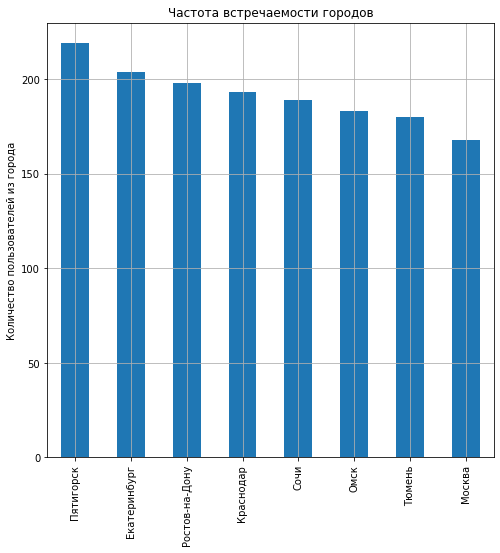

In [11]:
users['city'].value_counts().plot(kind='bar',
                                  figsize=(8, 8),
                                  title='Частота встречаемости городов',
                                  grid=True
                                 )
plt.ylabel('Количество пользователей из города')
plt.show()

Визуализировав колонку **'city'** мы видим, что большинство пользователей живут в Пятигорске, а меньшинство - в Москве. Возможно, в столицу компания пришла недавно. Остальные города распределенны примерно одинаково в процентном соотношении

### Соотношение пользователей с подпиской и без подписки

Данные о статусе подписки находятся в датафрейме users

In [12]:
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

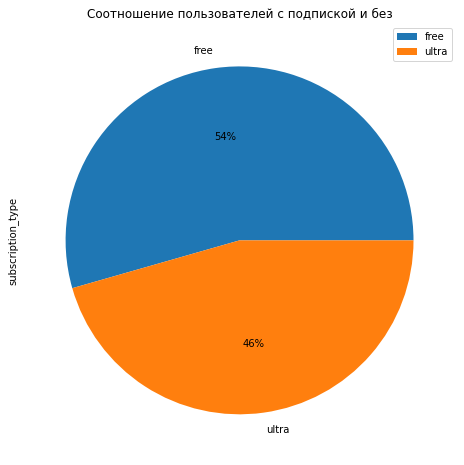

In [13]:
users['subscription_type'].value_counts().plot(kind='pie',
                                  autopct='%1.0f%%',
                                  figsize=(8, 8),
                                  legend=True,
                                  title='Соотношение пользователей с подпиской и без'
                                 )
plt.show()

Визуализировав столбец с данными о типе подписки, можно сделать вывод, что большинство пользователей пользуются бесплатной подпиской, но не подавляющее большинство - пользователей с платной подпиской 46%

### Возраст пользователей

Данные о возрасте пользователей находятся так же в датафрейме users

In [14]:
display(users['age'].min())
display(users['age'].max())

12

43

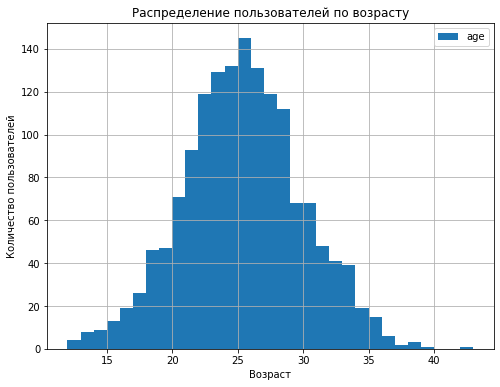

In [15]:
users['age'].hist(range=(12, 43), bins=31, figsize=(8, 6), legend=True, grid=True) 
#количество корзин: возраст максимальный - минимальный, чтобы для каждого года была своя правдивая статистика
plt.title('Распределение пользователей по возрасту')
plt.xlabel("Возраст")
plt.ylabel("Количество пользователей")
plt.show()

Самым младшим пользователям проката самокатов - 12 лет, а старшим - 43. Самый популярный возраст - 25. В основном прокатом самокатов пользуются люди 22-28 лет

### Расстояние, которое пользователь преодолел за одну поездку

Информация о расстоянии поездки находится в датафрейме rides, столбец - distance

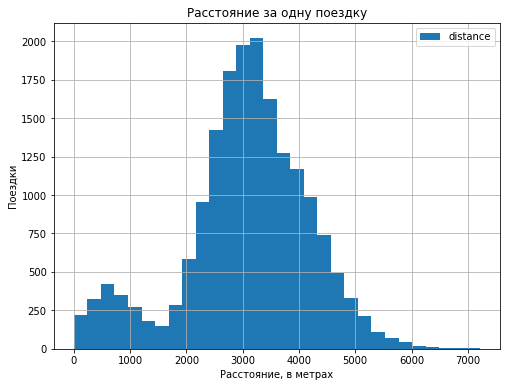

<function matplotlib.pyplot.show(close=None, block=None)>

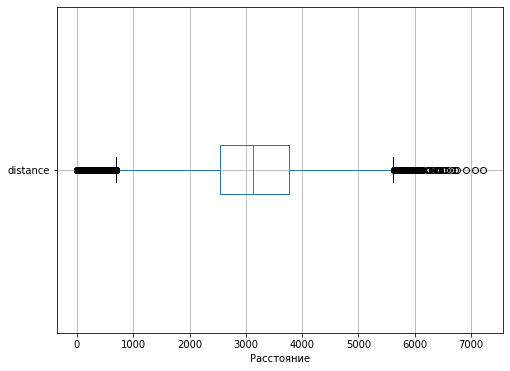

In [16]:
rides['distance'].hist(bins=30, figsize=(8, 6), legend=True, grid=True) 
plt.title('Расстояние за одну поездку')
plt.xlabel("Расстояние, в метрах")
plt.ylabel("Поездки")
plt.show()

rides.boxplot('distance', figsize=(8, 6), vert=False)
plt.xlabel('Расстояние')
plt.show

По графикам видно, что в основном, пользователи проезжаю 2,5 - 4,5 километра. Пик и медиана расположенны в районе 3000-3200 метров. Поездки больше, чем на 5,7 км и меньше, чем на 800 метров - можно считать выбросами, к тому же они встречаются не так часто

### Продолжительность поездок

Продолжительность поездок содержится в rides, столбец - duration

In [17]:
display(rides['duration'].min())
display(rides['duration'].max())

0.5

40.82396261922424

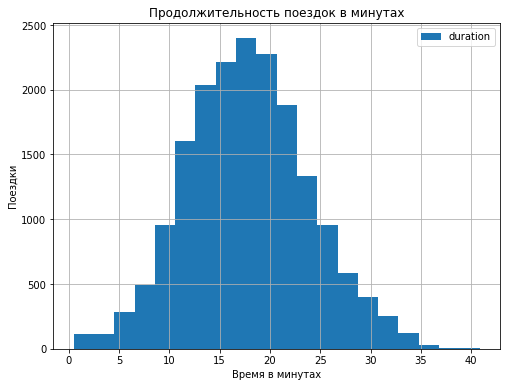

In [18]:
rides['duration'].hist(figsize=(8, 6), bins=20, grid=True, legend=True)
plt.title('Продолжительность поездок в минутах')
plt.xlabel('Время в минутах')
plt.ylabel('Поездки')
plt.show()

В большинстве случаев прокат самоката длится от 10 минут до 25 минут. Пик - поездка на 16-18 минут. Иногда, поездка длится совсем не долго - чуть меньше минуты - скорее всего пользователи случайно начали поездку, или передумали. Максимум - почти 41 минута

**Проанализировав общую информацию о поездках и пользователях, я пришел к выводу, что:**
- Большинство пользователей живут в Пятигорске, меньше всего - в Москве
- Большинство пользователей не пользуются подпиской, но разница с подписанными не особо большая 54% и 46% соответственно
- Прокатом пользуются в основном молодые 22-28 лет
- Чаще всего, поездка длится 10-25 минут, а проезжают 2,5-4,5 километра


## Шаг 4. Объединение данных

### Объединение датафреймов

In [19]:
data = pd.merge(users, rides, on='user_id')
data = pd.merge(data, subscriptions, on='subscription_type')
data #объединенный из 3 в 1 датафрейм

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [20]:
data_with_sub = data.query('subscription_type == "ultra"') #создание датафрейма с пользователями, у которых есть подписка
data_without_sub = data.query('subscription_type == "free"') #создание датафрейма с пользователями без подписки
display(data_with_sub.shape)
display(data_without_sub.shape)

(6500, 12)

(11568, 12)

### Визуализация данных объединенных датафреймов

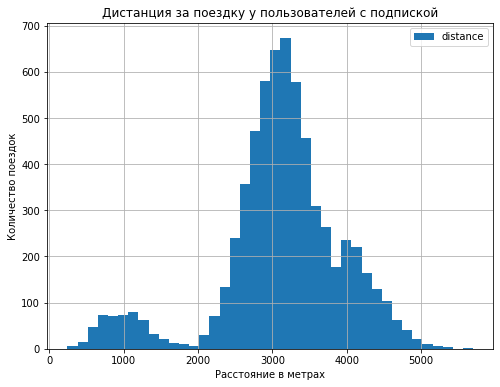

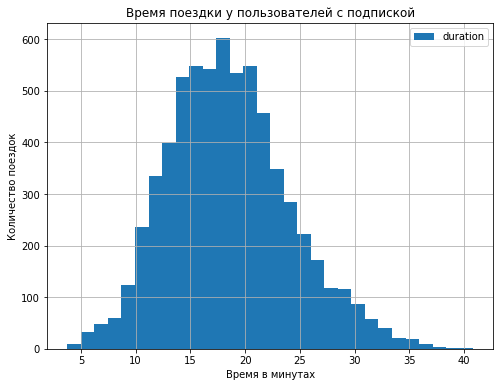

In [21]:
data_with_sub['distance'].hist(bins=40, figsize=(8, 6), legend=True)
plt.title('Дистанция за поездку у пользователей с подпиской')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.show()
data_with_sub['duration'].hist(bins=30, figsize=(8, 6), legend=True)
plt.title('Время поездки у пользователей с подпиской')
plt.xlabel('Время в минутах')
plt.ylabel('Количество поездок')
plt.show()

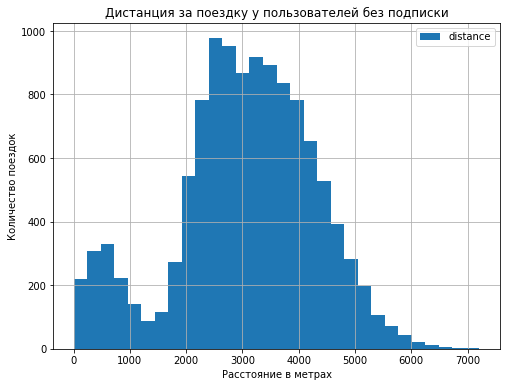

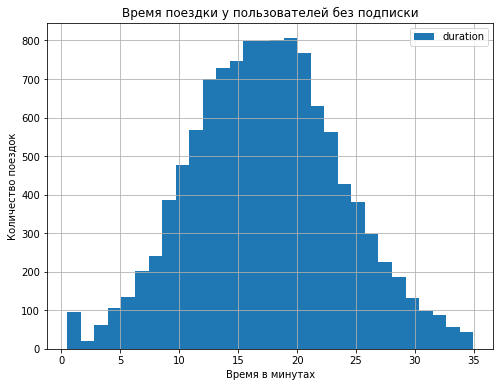

In [22]:
data_without_sub['distance'].hist(bins=30, figsize=(8, 6), legend=True)
plt.title('Дистанция за поездку у пользователей без подписки')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.show()
data_without_sub['duration'].hist(bins=30, figsize=(8, 6), legend=True)
plt.title('Время поездки у пользователей без подписки')
plt.xlabel('Время в минутах')
plt.ylabel('Количество поездок')
plt.show()

Гистограммы для пользователей с подпиской и для пользователей без подписки различаются, для большей наглядности можно построить пересекающиеся гистограммы

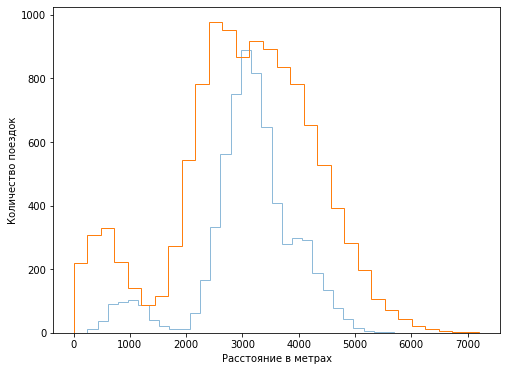

In [23]:
data_with_sub['distance'].plot(kind='hist', histtype='step', bins=30, figsize=(8,6), alpha=0.5)
data_without_sub['distance'].plot(kind='hist', histtype='step', bins=30, alpha=1)
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.show()

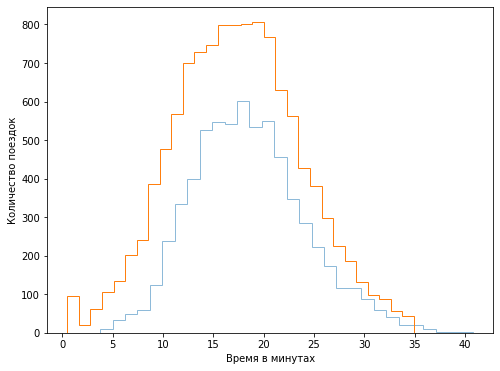

In [24]:
data_with_sub['duration'].plot(kind='hist', histtype='step', bins=30, figsize=(8,6), alpha=0.5)
data_without_sub['duration'].plot(kind='hist', histtype='step', bins=30, alpha=1)
plt.xlabel('Время в минутах')
plt.ylabel('Количество поездок')
plt.show()

После объединения данных методом merge, можно сделать вывод, что расстояние, которое проезжают пользователи с подпиской и без различается - пользователи с подпиской проезжают, в основном, 2,5-3,7 километра, а пользователи без подписки - 2-4,5 километра. Для бесплатного тарифа время поездки 10-25 минут, а для платного - 12-23 минуты. Количество данных по поездкам больше для бесплатных пользователей. **Подписка влияет на расстояние поездок и на время в пути**

## Шаг 5. Подсчёт выручки

Помесячная выручка считается по формуле: (стоимость старта поездки ×  количество поездок) + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки.

In [25]:
data_pivot = data.pivot_table(index=['user_id', 'month'], 
                              values=['distance', 'duration', 'name', 'start_ride_price', 'minute_price', 'subscription_fee'],
                             aggfunc={'distance': sum, 'duration': sum, 'name': len, 'start_ride_price': 'mean', 'minute_price': 'mean', 'subscription_fee': 'mean'})
data_pivot.head()

distance   duration  minute_price  name  start_ride_price  \
user_id month                                                                 
1       1      7027.511294  41.416640             6     2                 0   
        4       754.159807   6.232113             6     1                 0   
        8      6723.470560  44.776802             6     2                 0   
        10     5809.911100  31.578017             6     2                 0   
        11     7003.499363  53.397424             6     3                 0   

               subscription_fee  
user_id month                    
1       1                   199  
        4                   199  
        8                   199  
        10                  199  
        11                  199

Создали сводную таблицу, где для каждого пользователя по месяцу расписанны параметры дистанции, продолжительности, цены за минуту, за начало поездки, за подписку

In [26]:
data_pivot = data_pivot.rename(columns = {'name':'rides_count'}) #переименовываем для удобства
data_pivot['duration'] = np.ceil(data_pivot['duration']) #округляем длительность по потолку значений

In [27]:
data_pivot['month_cash'] = (data_pivot['start_ride_price'] * 
                            data_pivot['rides_count']) + (data_pivot['minute_price'] * 
                                                          data_pivot['duration']) + data_pivot['subscription_fee']
data_pivot.head()

distance  duration  minute_price  rides_count  \
user_id month                                                     
1       1      7027.511294      42.0             6            2   
        4       754.159807       7.0             6            1   
        8      6723.470560      45.0             6            2   
        10     5809.911100      32.0             6            2   
        11     7003.499363      54.0             6            3   

               start_ride_price  subscription_fee  month_cash  
user_id month                                                  
1       1                     0               199       451.0  
        4                     0               199       241.0  
        8                     0               199       469.0  
        10                    0               199       391.0  
        11                    0               199       523.0

In [28]:
print(data['date'].min(), data['date'].max()) 

2021-01-01 00:00:00 2021-12-30 00:00:00


Данные представлены за 1 год - **2021**

In [29]:
print('Выручка GoFast за 2021 год', data_pivot['month_cash'].sum(), 'рублей')

Выручка GoFast за 2021 год 3853677.0 рублей


,month_cash
month,
1,335864.0
2,288770.0
3,327712.0
4,320760.0
5,334981.0
6,333830.0
7,326454.0
8,323500.0
9,320963.0


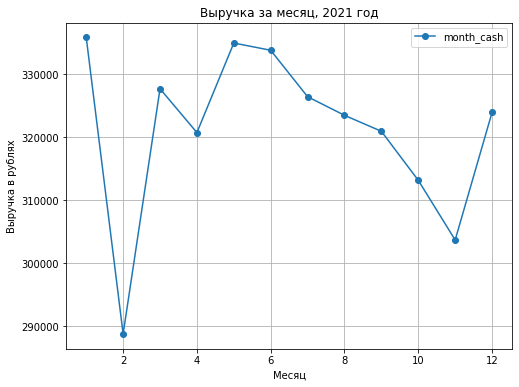

In [30]:
monthly_value = data_pivot.pivot_table(index='month', values='month_cash', aggfunc='sum')
display(monthly_value)#выручка компании за каждый месяц
monthly_value.plot(grid=True, figsize=(8, 6), style='-o')
plt.title('Выручка за месяц, 2021 год')
plt.xlabel('Месяц')
plt.ylabel('Выручка в рублях')
plt.show()

In [31]:
ultra = (data_pivot.query('subscription_fee == 199'))
free = (data_pivot.query('subscription_fee == 0'))
display(ultra['month_cash'].sum())
display(free['month_cash'].sum())

1638597.0

2215080.0

Изучив выручку, я пришел к выводу, что компания за год заработала 3,85 миллиона рублей. Также, провел дополнительный анализ по сумме выручки за каждый месяц. Выручка в феврале - рекордно низкая, по сравнению с другими месяцами. Пользователи с подпиской принесли компании 1.63 миллиона рублей за год, а пользователи без подписки - 2.21 миллиона рублей

## Шаг 6. Проверка гипотез

### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Сформулируем гипотезы: 
- H0: время поездки у пользователей с подпиской и без равны
- H1: время поездки у пользователей с подпиской больше, чем у пользователей без подписки

In [32]:
test = st.ttest_ind(data_with_sub['duration'],
             data_without_sub['duration'],
             equal_var=True,
             alternative='greater'
            )
alpha = 0.05

print('p-value =', test.pvalue)

if test.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value = 1.2804098316645618e-34
Отвергаем нулевую гипотезу


При уровне значимости в 5% нулевая гипотеза была отвергнута, что значит, что **время поездки у пользователей с подпиской больше, чем у пользователей без подписки**

### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

Сформулируем гипотезы:
- H0: Пользователи с подпиской проезжают оптимальные 3130 метров за одну поездку
- H1: Пользователи с подпиской проезжают больше 3130 метров за одну поездку

In [33]:
value = 3130
alpha = 0.05

test = st.ttest_1samp(data_with_sub['distance'],
                     value,
                     alternative='greater'
                     )

print('p-value =', test.pvalue)

if test.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value = 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


При уровне значимости в 5% не удалось отвергнуть нулевую гипотезу, что говорит о том, что **пользователи с подпиской проезжают расстояние не превышающее оптимальное, с точки зрения износа самоката - 3130**

### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

Сформулируем гипотезы:
- H0: Пользователи с подпиской приносят столько же выручки, как и пользователи без подписки (в месяц)
- H1: Пользователи с подпиской приносят больше выручки, чем пользователи без подписки (в месяц)

In [34]:
test = st.ttest_ind(ultra['month_cash'],
             free['month_cash'],
             equal_var=True,
             alternative='greater'
            )
alpha = 0.05

print('p-value =', test.pvalue)

if test.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value = 2.8130926188487286e-35
Отвергаем нулевую гипотезу


При уровне значимости в 5% мы отвергли нулевую гипотезу, значит можно говорить, что **пользователи с подпиской приносят больше месячной выручки, чем пользователи без подписки**

### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?


Это две выборки, которые прошли через изменения, значит, нам нужно проверить гипотезу о равенстве среднего значения генеральной совокупности до и после изменения. Для этого отлично подходит **scipy.stats.ttest_rel**, в которой аргументами будут два набора данных - до обновления и после него. При проверке H0 на равенство истинного среднего генеральной совокупности, мы надеемся увидеть снижение количества обращений, значит H1 мы формулируем в левую сторону, задавая параметр **alternative="less"**.

Вывод по гипотезам:
- при проверке первой гипотезы, стало понятно, что, действительно - время поездки у пользователей с подпиской больше, чем у пользователей без подписки
- при проверке второй гипотезы, я увидел, что действительно, в большинстве случаев, пользователи с подпиской проезжают расстояние до 3130 метров, оптимального расстояния с точки зрения износа самокатов
- при проверке третьей гипотезы, я установил, что помесячная выручка от пользователей с подпиской действительно выше, чем от пользователей без подписки
- описал какой тест понадобится для проверки данных о количестве обращений до и после обновления

## Шаг 7. Распределения

### Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [35]:
k = 100 #цель
n = 1000 #количество попыток минимальное при вероятности продления 0.1
p = 0.1 #вероятность продления
ver = 0.05 #цель по процентам
binom.cdf(k, n, p)

0.5265990812951653

При количестве попыток = 1000, вероятность не выполнить план - 52%. Нужно прибавлять n 

In [36]:
while binom.cdf(k, n, p) > ver:
    n+=1
    
print(n)
print(binom.cdf(k, n, p))

1172
0.04954795210203071


При количестве попыток: 1172, вероятность не выполнить план примерно 5%

### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [37]:
k = 399500
n = 1000000
p = 0.4

binom.cdf(k, n, p)

0.1539584359564276

При вероятности открытия уведомлений в 40%, разослав 1 миллион уведомлений, шанс того, что эти уведомления откроет не более 399,5 тысяч пользователей равна 15,4%

Проанализировав распределения, можно сделать вывод, что **при количестве попыток: 1172, вероятность не выполнить план примерно 5%**, а шанс что уведомления откроют не более, чем 399,5 тыс. пользователей **равна 15,4%**

## Общий вывод

В ходе работы над проектом, были выполнены все пункты ТЗ:

- загрузил данные датаестов, проверил общую информацию 
- предобработал данные датасетов, удалил дубликаты, изменил формат столбца date, после обработки данных осталось более 90% информации
- описал и визуализировал общую информацию о пользователях и поездках:
1. Большинство пользователей живут в Пятигорске, меньше всего - в Москве
2. Большинство пользователей не пользуются подпиской, но разница с подписанными не особо большая 54% и 46% соответственно
3. Прокатом пользуются в основном молодые люди 22-28 лет
4. Чаще всего, поездка длится 10-25 минут, а проезжают 2,5-4,5 километра

- объединил датафреймы в отдельный датафрейм методом merge, визуализировал информацию о расстоянии и времени поездок: расстояние, которое проезжают пользователи с подпиской и без различается, подписка влияет на расстояние поездок и на время в пути
- создал датафрейм с агрегированными данными о поездках data_pivot
- добавил столбец с помесячной выручкой, которую принёс каждый пользователь, создал датафреймы из data_pivot для подписчиков ultra и пользователей free
- проверил 4 гипотезы:
1. Время поездки у пользователей с подпиской больше, чем у пользователей без подписки
2. Чаще всего, пользователи с подпиской проезжают расстояние до 3130 метров, оптимального расстояния с точки зрения износа самокатов
3. Помесячная выручка от пользователей с подпиской действительно выше, чем от пользователей без подписки
4. Для проверки данных о количестве обращений до и после обновления понадобится воспользоваться тестом scipy.stats.ttest_rel(), задавая параметр alternative='less'
- Установил распределения: при количестве попыток: 1172, вероятность не выполнить план примерно 5%, а шанс что уведомления откроют не более, чем 399,5 тыс. пользователей равна 15,4%